# Проект: Рекомендательная система книг на основе гибридного метода (ALS + CatBoost)

## Описание проекта
---
### Цель проекта
- Разработать рекомендательную систему книг, сочетающую коллаборативную фильтрацию (ALS) и контентные признаки (CatBoost).
- Основная задача — повысить качество рекомендаций за счет комбинации двух подходов: матричной факторизации и классификации на основе признаков книг и пользователей.
- Проверить гипотезу о том, что гибридный метод превзойдет базовую модель ALS по метрике mAP@10.

---

### Этапы выполнения проекта

1. **Подготовка данных и создание user-item-матрицы**
   - Загрузка данных: книги (`books.csv`), рейтинги (`ratings.csv`), жанры (`goodreads_book_genres_initial.json`)
   - Бинаризация рейтингов (оценка ≥ 4 → 1, иначе → 0)
   - Разбиение данных на train/test (70/30) на основе порядка прочтения
   - Построение user-item-матрицы размера `53 424 × 10 000`

2. **Применение метода матричной факторизации и создание бейзлайна**
   - Реализация функции `ap_at_k()` для расчета Average Precision at K
   - Обучение базовой модели ALS (`factors=50`, `iterations=15`)
   - Расчет **mAP@10 для ALS (базовый): 0,047412**

3. **Сбор контентных признаков и обучение классификатора**
   - Извлечение признаков пользователей (статистика оценок, жанровые предпочтения)
   - Извлечение признаков книг (средний рейтинг, количество оценок, жанры)
   - One-hot кодирование жанров книг
   - Обучение и калибровка CatBoostClassifier с учетом дисбаланса классов

4. **Реализация гибридного метода и оценка качества**
   - Получение рекомендаций от ALS (до 30 книг на пользователя)
   - Ранжирование кандидатов с помощью CatBoost
   - Объединение оценок ALS и CatBoost с оптимальным весом
   - Расчет **mAP@10 для гибридной модели: 0,050410**

5. **Сравнение моделей и оптимизация весов**
   - Поиск оптимального веса между ALS и CatBoost (от 0 до 1)
   - Визуализация результатов по качеству и скорости работы

---

### Результаты моделей (метрика mAP@10)

- **Модель ALS (базовые параметры): `0.047412`**
- **Гибридная модель (ALS + CatBoost): `0.050410`**

#### Улучшение гибридной модели относительно базового ALS:
- Абсолютное: **+0,003 п.п.**
- Относительное: **+6,3%**

---

### Основные выводы

1. **Эффективность гибридного подхода**:
   - Комбинация ALS и CatBoost улучшила качество рекомендаций на 6,3%.
   - Гибридный метод лучше учитывает как коллаборативные взаимодействия, так и контентные характеристики.

2. **Влияние весового коэффициента**:
   - Наилучший результат достигнут при равном весе ALS и CatBoost (`weight_coef = 0.5`).
   - Увеличение доли CatBoost сверх 0,5 снижает качество, что указывает на важность коллаборативной составляющей.

3. **Производительность моделей**:
   - ALS работает значительно быстрее (0,5 сек) за счёт матричной факторизации.
   - Гибридный метод требует больше времени (8,7 сек) из-за генерации признаков и предсказаний CatBoost.

4. **Практическая значимость**:
   - Гибридный подход обеспечивает более персонализированные и релевантные рекомендации.

### Итог
- Разработана гибридная рекомендательная система, сочетающая матричную факторизацию (ALS) и классификацию на основе признаков (CatBoost).
- Гибридная модель превзошла базовый ALS по метрике mAP@10 на 6,3%, подтвердив эффективность комбинированного подхода.
- Проект продемонстрировал, что объединение коллаборативных и контентных методов позволяет улучшить качество персонализации в рекомендательных системах.

## Импорт библиотек

In [318]:
import numpy as np
import pandas as pd
import time
import itertools
import matplotlib.pyplot as plt

from pandas.api.types import CategoricalDtype
import scipy.sparse as sparse
# from scipy.spatial.distance import cdist
import implicit

# from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score, 
                             precision_score, recall_score, log_loss,
                             confusion_matrix, classification_report)

from catboost import CatBoostClassifier

In [319]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
# import warnings
# warnings.filterwarnings("ignore")

## Загрузка данных

#### Книги - books.csv

In [320]:
books = pd.read_csv('./data/books.csv')
print(books.shape)
books.head(3)

(10000, 23)


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...


#### Рейтинги книг - ratings.csv

In [321]:
dtype_dict = {
    'user_id': 'uint32',    # 53,424 уникальных значений < 65,535
    'book_id': 'uint16',    # 10,000 уникальных значений < 65,535
    'rating':  'uint8'      # значения от 1 до 5
}

ratings = pd.read_csv('./data/ratings.csv', dtype=dtype_dict)
print(ratings.shape)
ratings.head(3)

(5976479, 3)


,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5


In [322]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   user_id  uint32
 1   book_id  uint16
 2   rating   uint8 
dtypes: uint16(1), uint32(1), uint8(1)
memory usage: 39.9 MB


In [323]:
print(f'Количество уникальных значений:')
print(f'\tusers:   {ratings['user_id'].nunique():6,}')
print(f'\tbooks:   {ratings['book_id'].nunique():6,}')
print(f'\tratings: {ratings['rating'].nunique():6,}')

Количество уникальных значений:
	users:   53,424
	books:   10,000
	ratings:      5


#### Жанры книг - goodreads_book_genres_initial.json

In [324]:
genres = pd.read_json( './data/goodreads_book_genres_initial.json.gz',
                        # compression='gzip',
                        lines=True
)
print(genres.shape)
genres.head(3)

(2360655, 2)


,book_id,genres
0,5333265,"{'history, historical fiction, biography': 1}"
1,1333909,"{'fiction': 219, 'history, historical fiction,..."
2,7327624,"{'fantasy, paranormal': 31, 'fiction': 8, 'mys..."


In [325]:
print(f'Всего было книг с жанрами: {genres.shape}')

# Оставляем только книги, которые есть в books
genres = genres[ genres.book_id.isin( books['goodreads_book_id'] ) ]
print(f'Осталось книг в датасете:  {genres.shape}')

genres.columns = ['goodreads_book_id', 'genres_dict']

# Добавляем book_id в genres, удаляем goodreads_book_id
genres = genres.merge(
    books[ ['book_id', 'goodreads_book_id'] ],
    left_on  = 'goodreads_book_id',
    right_on = 'goodreads_book_id',
    how      = 'left'
)
genres.drop(columns=['goodreads_book_id'], inplace=True, errors='ignore')

all_genres = set()
for dict_genre in genres.genres_dict:
    for genre in list(dict_genre.keys()):
        all_genres.add(genre)

print(f'Список жанров:')
for i, genre in enumerate( sorted( all_genres)):
    print(f'\t{i + 1:>2}. {genre}')

Всего было книг с жанрами: (2360655, 2)
Осталось книг в датасете:  (9996, 2)
Список жанров:
	 1. children
	 2. comics, graphic
	 3. fantasy, paranormal
	 4. fiction
	 5. history, historical fiction, biography
	 6. mystery, thriller, crime
	 7. non-fiction
	 8. poetry
	 9. romance
	10. young-adult


In [326]:
# On-hot кодирование книг по жанрам

def simple_one_hot(genre_dict, genre):
    """On-hot кодирование книг по жанрам"""
    if genre in genre_dict:
        return 1
    return 0
    
for genre in all_genres:
    genres[genre] = 0

for genre in all_genres:
    genres[genre] = genres.apply( lambda df: simple_one_hot( df['genres_dict'], genre ), axis=1)
    
genres.head(3)

,genres_dict,book_id,"fantasy, paranormal","mystery, thriller, crime",fiction,poetry,non-fiction,"history, historical fiction, biography",romance,"comics, graphic",young-adult,children
0,"{'fiction': 555, 'romance': 23, 'mystery, thri...",1879,0,1,1,0,0,0,1,0,0,0
1,"{'non-fiction': 534, 'history, historical fict...",1097,0,0,1,0,1,1,0,1,0,0
2,"{'history, historical fiction, biography': 108...",4399,0,0,0,0,1,1,0,1,0,0


## Часть 1

### Подготовка данных

#### Новые вспомогательные признаки
- **`rating_binary`** - бинарный рейтинг (значения: 1, если rating >= 4, иначе 0)
- **`book_order`** - номер книги по порядку для каждого конкретного пользователя
- **`book_order_normalized`** - доля прочитанных книг (нарастающий итог)
- **`count_books`** - общее количество прочитанных книг у пользователя
- **`is_train_data`** - тренировочные и тестовые данные (значения 1 или 0)

In [327]:
# Что считаем хорошей оценкой:
GOOD_RATING = 4    # и выше
TRAIN_SIZE  = 0.7  # доля тренировочных данных (прочитанных книг для каждого пользователя)

In [328]:
# Бинарный рейтинг - значения: 1, если rating >= GOOD_RATING, иначе 0
ratings['rating_binary'] = (ratings['rating'] >= GOOD_RATING).astype('uint8')

# Общее количество книг для каждого пользователя
ratings['count_books'] = ratings.groupby('user_id')['rating'].transform('count')

# Номер книги по пордяку для каждого конкретного пользователя
ratings['book_order'] = ratings.groupby('user_id').cumcount() + 1

# Доля прочитанных книг (нарастающий итог)
ratings['book_order_normalized'] = ratings['book_order'] / ratings['count_books']

# Доля и признак тренировочных данных
ratings['is_train_data'] = (ratings['book_order_normalized'] < TRAIN_SIZE).astype('uint8')

#### Пример данных для пользователя с user_id = ...

In [329]:
# Пример данных для пользователя с user_id = ...
# user_ids_list = [1, 26, 40753, 7607, 26183, 41890, 52153, 45394]
ratings[ ratings['user_id'] == 45394].merge(books[ ['book_id', 'original_title'] ], on='book_id')

,user_id,book_id,rating,rating_binary,count_books,book_order,book_order_normalized,is_train_data,original_title
0,45394,2686,3,0,120,1,0.008333,1,Blue Ocean Strategy: How to Create Uncontested...
1,45394,51,5,1,120,2,0.016667,1,City of Bones
2,45394,434,5,1,120,3,0.025000,1,Crescendo
3,45394,3165,5,1,120,4,0.033333,1,NaN
4,45394,1,5,1,120,5,0.041667,1,The Hunger Games
5,45394,5,4,1,120,6,0.050000,1,The Great Gatsby
6,45394,38,3,0,120,7,0.058333,1,The Time Traveler's Wife
7,45394,33,5,1,120,8,0.066667,1,Memoirs of a Geisha
8,45394,3,2,0,120,9,0.075000,1,Twilight
9,45394,39,5,1,120,10,0.083333,1,A Game of Thrones


### user-item-матрица

In [330]:
%%time
user_index  = ratings.user_id.unique()
books_index = ratings.book_id.unique()

rows = ratings['user_id'].astype( CategoricalDtype( categories = user_index) ).cat.codes
cols = ratings['book_id'].astype( CategoricalDtype( categories = books_index) ).cat.codes

matrix = sparse.csr_matrix( 
    (ratings.rating_binary, (rows, cols)), 
    shape=( len(user_index), len(books_index) ) 
)
matrix = matrix.toarray()

print(f'Размер матрицы: {matrix.shape}\n')

Размер матрицы: (53424, 10000)

CPU times: total: 438 ms
Wall time: 462 ms


#### Вывод всех высоких оценок пользователя

In [331]:
# user_id_example_list = [40753, 7607, 52153, 45394]
user_id_example = 45394
# user_id_example = 14147

# index пользователя с user_id = user_id_example
idx_user_example = np.where(user_index == user_id_example)[0][0]
print('-' * 100)
print(f'user_id (example)  = {user_id_example}\nidx_user (example) = {idx_user_example}')
print('-' * 100)
i = 0
for ind, score in enumerate( matrix[ idx_user_example ] ):
    if score == 1:
        i += 1
        book_id = books_index[ind]
        print(f'   {i:>3};   ind = {ind:>5};' + 
              f'   book_id = {book_id:>5};' + 
              f'   score = {score};' + 
              f'   books = {books[ books['book_id'] == book_id ].original_title.values[0]}' )

----------------------------------------------------------------------------------------------------
user_id (example)  = 45394
idx_user (example) = 42789
----------------------------------------------------------------------------------------------------
     1;   ind =     6;   book_id =   315;   score = 1;   books = Who Moved My Cheese?
     2;   ind =     7;   book_id =    33;   score = 1;   books = Memoirs of a Geisha
     3;   ind =    32;   book_id =     5;   score = 1;   books = The Great Gatsby
     4;   ind =   142;   book_id =    10;   score = 1;   books = Pride and Prejudice
     5;   ind =   145;   book_id =    94;   score = 1;   books = Cien años de soledad
     6;   ind =   381;   book_id =    39;   score = 1;   books = A Game of Thrones
     7;   ind =   412;   book_id =   272;   score = 1;   books = Como agua para chocolate
     8;   ind =   740;   book_id =    37;   score = 1;   books = The Lion, the Witch and the Wardrobe
     9;   ind =   741;   book_id =   602;   s

In [332]:
if False:
    viwed_arr = np.where( matrix[idx_user_example] > 0)[0]
    viwed_arr

### Выводы (Часть 1)

#### Подготовка данных и user-item-матрица
- Данные загружены, рейтинги бинаризованы (оценка ≥ 4)
- Добавлены признаки порядка прочтения, выполнено разделение на тренировочные и тестовые данные (70/30)
- Построена user-item-матрица `53 424 × 10 000`

## Часть 2

#### Функция для подсчета AP@K

In [333]:
def ap_at_k( recommended_items, relevant_user_items, k = 10, is_debug = False):
    """
    Расчет Average Precision at K (AP@K)
    
    Parameters:
        recommended_items:    список рекомендованных book_id
        relevant_user_items:  список book_id с положительной оценкой (4 или 5)
        k:                    количество рекомендаций для оценки
    
    Returns:
        AP@K значение
    """
	
    if is_debug:
        print(f'recommended_items   = {recommended_items}')
        print(f'relevant_user_items = {relevant_user_items}')
    
    if len(recommended_items) == 0:
        return 0.0
    
    # Берем первые k рекомендаций
    recommended_items = recommended_items[:k]
    
    score    = 0.0
    num_hits = 0.0
    
    for i, item in enumerate(recommended_items):
        if item in relevant_user_items:
            # print(f'\t\tКнига совпала!  user_id = {user_id};  book_id = {item}')
            if is_debug:
                print(f'\t{i:3}.   book_id = {item:5};   (+)   Книга ЕСТЬ в списке relevant_user_items')
            num_hits += 1.0
            score    += num_hits / (i + 1.0)
        else:
            if is_debug:
                print(f'\t{i:3}.   book_id = {item:5};    -    Книги НЕТ в списке relevant_user_items')
    
    if len(relevant_user_items) == 0:
        return 0.0

    # if is_debug:
    #     print(f'score = {score}')
    #     print(f'min(len(relevant_user_items), k) = {min(len(relevant_user_items), k)}')

    score_res = score / min(len(relevant_user_items), k) 
    
    return score_res

In [334]:
# ТЕСТ - Проверка функции на простом примере
test_recommended = [1, 2, 3, 4, 5]
test_relevant    = [2, 5]

print('-' * 100)
k = 3
print(f'\nAP@{k} = {ap_at_k( test_recommended, test_relevant, k, is_debug=True )}')

print('-' * 100)
k = 5
print(f'\nAP@{k} = {ap_at_k( test_recommended, test_relevant, k, is_debug=True )}')

----------------------------------------------------------------------------------------------------
recommended_items   = [1, 2, 3, 4, 5]
relevant_user_items = [2, 5]
	  0.   book_id =     1;    -    Книги НЕТ в списке relevant_user_items
	  1.   book_id =     2;   (+)   Книга ЕСТЬ в списке relevant_user_items
	  2.   book_id =     3;    -    Книги НЕТ в списке relevant_user_items

AP@3 = 0.25
----------------------------------------------------------------------------------------------------
recommended_items   = [1, 2, 3, 4, 5]
relevant_user_items = [2, 5]
	  0.   book_id =     1;    -    Книги НЕТ в списке relevant_user_items
	  1.   book_id =     2;   (+)   Книга ЕСТЬ в списке relevant_user_items
	  2.   book_id =     3;    -    Книги НЕТ в списке relevant_user_items
	  3.   book_id =     4;    -    Книги НЕТ в списке relevant_user_items
	  4.   book_id =     5;   (+)   Книга ЕСТЬ в списке relevant_user_items

AP@5 = 0.45


#### Подготовка данных для оценки

In [335]:
%%time
np.random.seed(42)      # для воспроизводимости результатов

#----------------------------------------------------------------------------------------------------------------
# Словарь (user_items_all)           - для каждого пользователя - все его книги
# Словарь (user_items_train)         - для каждого пользователя - тренировочная выборка - все его книги
# Словарь (user_items_test)          - для каждого пользователя - тестовая выборка      - все его книги
# Словарь (user_items_test_positive) - для каждого пользователя - тестовая выборка      - все его положительно оцененные книги

user_items_all   = ratings.groupby('user_id')['book_id'].apply(set).to_dict()

df_ratings_train = ratings[ (ratings['is_train_data'] == 1) ]
user_items_train = df_ratings_train.groupby('user_id')['book_id'].apply(list).to_dict()

df_ratings_test = ratings[ (ratings['is_train_data'] == 0) ]
user_items_test = df_ratings_test.groupby('user_id')['book_id'].apply(list).to_dict()

df_positive_ratings_test = ratings[ (ratings['rating'] >= GOOD_RATING) & (ratings['is_train_data'] == 0) ]
user_items_test_positive = df_positive_ratings_test.groupby('user_id')['book_id'].apply(list).to_dict()

#----------------------------------------------------------------------------------------------------------------
# Все пользователи, у которых есть положительные оценки в тестовой выборке
users_positive_test = list(user_items_test_positive.keys())

# Книги с положительными оценками во всей выборке
# Книги с положительными оценками из тестовой выборки
books_positive      = ratings[ (ratings['rating'] >= GOOD_RATING) ]['book_id'].unique()
books_positive_test = ratings[ (ratings['rating'] >= GOOD_RATING) & (ratings['is_train_data'] == 0)]['book_id'].unique()

#----------------------------------------------------------------------------------------------------------------
# Выбираем 500 случайных пользователей из списка users_positive_test (если пользователей меньше 500, то берем всех)
cnt_random_users = 500

if len(users_positive_test) < cnt_random_users:
    random_user_ids = users_positive_test
else:
    random_user_ids = np.random.choice( users_positive_test, size = cnt_random_users, replace = False)

#----------------------------------------------------------------------------------------------------------------
print('-' * 100)
print(f"Всего пользователей с положительными оценками (в тесте):  {len(users_positive_test)}")
print('-' * 100)
print(f"Выбрано пользователей:  {len(random_user_ids)}")
print(f"Первые 10 user_id:      {random_user_ids[:10]}\n")

#----------------------------------------------------------------------------------------------------------------
print('-' * 100)
print(f"Всего книг с положительными оценками:                       {len(books_positive)}")
print(f"Первые 10 книг book_id с положительными оценками:           {books_positive[:10]}\n")
print('-' * 100)
print(f"Всего книг с положительными оценками (в тесте):              {len(books_positive_test)}")
print(f"Первые 10 книг book_id с положительными оценками (в тесте):  {books_positive_test[:10]}\n")

#----------------------------------------------------------------------------------------------------------------
del df_ratings_train, df_ratings_test, df_positive_ratings_test

----------------------------------------------------------------------------------------------------
Всего пользователей с положительными оценками (в тесте):  53354
----------------------------------------------------------------------------------------------------
Выбрано пользователей:  500
Первые 10 user_id:      [14147 24520 22505 13488 36337 51323 48690 44559 44727 31669]

----------------------------------------------------------------------------------------------------
Всего книг с положительными оценками:                       10000
Первые 10 книг book_id с положительными оценками:           [ 258 4081  260 9296   26   33  301 2686 3753 8519]

----------------------------------------------------------------------------------------------------
Всего книг с положительными оценками (в тесте):              10000
Первые 10 книг book_id с положительными оценками (в тесте):  [ 618 5508 4707    2 3457 5283  354  468 1373  117]

CPU times: total: 8.36 s
Wall time: 9 s


In [336]:
if False:
    # Примеры - Пользователи и их книги с положительными оценками (из тестовой выборки)
    for i, (k, v) in enumerate(user_items_test_positive.items()):
        if i == 5: break
        print(f'{i + 1}.  user_id = {k};  cnt_books = {len(v):>3};  books_ids = {v}')

### Применение метода матричной факторизации

In [337]:
# Создаем user-item матрицу для обучения (только train данные)
train_ratings = ratings[ ratings['is_train_data'] == 1 ]

# Подготавливаем разреженную матрицу для implicit
train_rows = train_ratings['user_id'].astype( CategoricalDtype(categories = user_index) ).cat.codes
train_cols = train_ratings['book_id'].astype( CategoricalDtype(categories = books_index) ).cat.codes

train_matrix = sparse.csr_matrix(
    ( train_ratings['rating_binary'].astype(float), (train_rows, train_cols) ),
    shape = ( len(user_index), len(books_index) )
)

print(f'Размеры матрицы = {train_matrix.shape}')

Размеры матрицы = (53424, 10000)


### Создание бейзлайна и расчет метрик

#### Модель ALS (baseline - базовые параметры)

In [338]:
%%time
# Инициализация и обучение модели ALS
model_als_base = implicit.als.AlternatingLeastSquares(
    factors=50,            # Количество факторов (скрытых признаков)
    iterations=15,         # Количество итераций
    regularization=0.01,
    random_state=42
)

# Обучение модели
model_als_base.fit(train_matrix, show_progress = True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: total: 39.5 s
Wall time: 2.79 s


In [339]:
# Модель ALS (лучшие параметры)
if False:
    %%time
    # Инициализация и обучение модели ALS с лучшими параметрами
    model_als_best = implicit.als.AlternatingLeastSquares(
        factors=300,           # Количество факторов (скрытых признаков)
        iterations=15,         # Количество итераций
        regularization=30,
        random_state=42
    )
    
    # Обучение модели
    model_als_best.fit(train_matrix, show_progress = True)

#### Пример рекомендаций (ALS базовые параметры) для пользователя с user_id = ...

In [340]:
# Пример - рекомендации для конкретного пользователя (user_id = ...)
# user_id_example_list  = [7607, 52153, 45394]
user_id_example  = 45394
idx_user_example = np.where(user_index == user_id_example)[0][0]
n_recommendations = 30

#--------------------------------------------------------------------------------------------------------
# Получаем рекомендации
recommendations = model_als_base.recommend(
    idx_user_example, 
    train_matrix[idx_user_example], 
    N=n_recommendations, 
    filter_already_liked_items=True,
    recalculate_user=True
)

item_indices, scores = recommendations
items_positive  = user_items_test_positive.get(user_id_example, [])

#--------------------------------------------------------------------------------------------------------
print('-' * 100)
print(f"Рекомендации для пользователя user_id: {user_id_example}:")
print(f"Количество рекомендаций: {len(item_indices)}")
print('-' * 100)

items_recommended = []
for i, (item_idx, score) in enumerate(zip(item_indices, scores)):
    
    book_id    = books_index[item_idx]
    book_title = books[books['book_id'] == book_id]['original_title'].values
    book_title = book_title[0] if len(book_title) > 0 else "Название не найдено"
    items_recommended.append(book_id)

    is_find = '+' if book_id in items_positive else '-'
    print(f"   {i+1:2}.   book_id = {book_id:5};   {is_find}    score = {score:.4f};   книга = {book_title}")

#--------------------------------------------------------------------------------------------------------
# Проверка рекомендаций расчет AP@K
k=10
ap_score_user   = ap_at_k( items_recommended, items_positive, k=k )
print('-' * 100)
print(f'Список книг пользователя = {items_positive}')
print(f"AP@{k:2} = {ap_score_user:.6f}\n")

----------------------------------------------------------------------------------------------------
Рекомендации для пользователя user_id: 45394:
Количество рекомендаций: 30
----------------------------------------------------------------------------------------------------
    1.   book_id =    73;   -    score = 0.6576;   книга = The Host
    2.   book_id =   183;   -    score = 0.6465;   книга = Clockwork Angel
    3.   book_id =   210;   +    score = 0.5407;   книга = nan
    4.   book_id =   351;   -    score = 0.4566;   книга = Clockwork Prince
    5.   book_id =   384;   +    score = 0.4545;   книга = Frostbite
    6.   book_id =   394;   +    score = 0.4416;   книга = Shadow Kiss
    7.   book_id =   418;   +    score = 0.4365;   книга = Spirit Bound
    8.   book_id =   419;   +    score = 0.4341;   книга = Blood Promise
    9.   book_id =   543;   +    score = 0.4005;   книга = Last Sacrifice 
   10.   book_id =     8;   -    score = 0.3986;   книга = The Catcher in the Rye


#### Расчет mAP@10 для модели ALS

In [341]:
def als_recommendations_for_user(user_idx, model, train_matrix, n_recommendations=20):
    """
    Получение рекомендаций от модели ALS для пользователя
    
    Parameters:
        user_idx:           индекс пользователя в матрице
        model:              обученная модель ALS
        train_matrix:       обучающая матрица
        n_recommendations:  количество рекомендаций
    
    Returns:
        Список рекомендованных book_id
    """
    item_indices, scores = model.recommend(
        user_idx, 
        train_matrix[user_idx], 
        N=n_recommendations, 
        filter_already_liked_items=True,
        # filter_items=None, 
        recalculate_user=True
    )
    
    # Список book_id из рекомендаций
    recommended_items = [ books_index[item_idx] for item_idx in item_indices]
    
    return recommended_items, scores

In [342]:
# Расчет mAP@10 для модели ALS
ap_score_all_als     = []
cnt_ap_score_nonzero = 0
n_recommendations    = 30
k = 10

print('-' * 100)
print(f'Формирование рекомендаций для {len(random_user_ids)} случайных пользователей')
print(f'Рекомендации - модель ALS (базовые параметры) (ТЕСТОВАЯ ВЫБОРКА)')
print(f'Количество рекомендаций = {n_recommendations}')
print(f'K = {k}')
print('-' * 100)

time_start = time.time()

for i, user_id in enumerate(random_user_ids):
    # Индекс пользователя
    user_idx = np.where(user_index == user_id)[0][0]
    
    # Получаем рекомендации от модели ALS
        # Получаем прочитанные книги пользователя (для исключения)
        # Получаем положительно оцененные книги пользователя в тестовой выборке
    items_read      = user_items_all.get( user_id, set())
    recommendations, als_scores = als_recommendations_for_user( user_idx, model_als_base, train_matrix, n_recommendations = n_recommendations)
    items_positive  = user_items_test_positive.get( user_id, [])
    
    # Рассчитываем AP@K
    ap_score = ap_at_k( recommendations, items_positive, k )
    
    ap_score_all_als.append(ap_score)
    mean_ap_als_base = np.mean(ap_score_all_als)

    if (i + 1) % 50 == 0:
        cnt_ap_score_nonzero = np.count_nonzero(np.array(ap_score_all_als))
        print(f'\tОбработано пользователей:   {i + 1:4} из {len(random_user_ids)};' + 
              f'   Кол-во ненулевых AP@k = {cnt_ap_score_nonzero:3};   mAP@{k} = {mean_ap_als_base:.6f}')

time_model_als_base = time.time() - time_start

print('-' * 100)
print(f'Количество ненулевых AP@{10:2}:                 {cnt_ap_score_nonzero}')
print(f'mAP@{k} для модели ALS (базовые параметры):  {mean_ap_als_base:.6f}')
print(f'Время работы алгоритма:                     {time_model_als_base:.1f} сек')
print('-' * 100)

----------------------------------------------------------------------------------------------------
Формирование рекомендаций для 500 случайных пользователей
Рекомендации - модель ALS (базовые параметры) (ТЕСТОВАЯ ВЫБОРКА)
Количество рекомендаций = 30
K = 10
----------------------------------------------------------------------------------------------------
	Обработано пользователей:     50 из 500;   Кол-во ненулевых AP@k =  26;   mAP@10 = 0.065148
	Обработано пользователей:    100 из 500;   Кол-во ненулевых AP@k =  51;   mAP@10 = 0.063931
	Обработано пользователей:    150 из 500;   Кол-во ненулевых AP@k =  74;   mAP@10 = 0.058726
	Обработано пользователей:    200 из 500;   Кол-во ненулевых AP@k =  98;   mAP@10 = 0.056323
	Обработано пользователей:    250 из 500;   Кол-во ненулевых AP@k = 125;   mAP@10 = 0.054607
	Обработано пользователей:    300 из 500;   Кол-во ненулевых AP@k = 150;   mAP@10 = 0.051004
	Обработано пользователей:    350 из 500;   Кол-во ненулевых AP@k = 177;   mAP@10

### Выводы (Часть 2)

#### Матричная факторизация (ALS)
- Реализована функция `ap_at_k()` для расчёта **Average Precision at K**
- Обучена базовая модель **ALS** (`factors=50`, `iterations=15`)
- **mAP@10 для ALS = 0,047412** – базовый уровень для сравнения

## Часть 3

#### Тренировочная выборка (для классификатора)

In [343]:
# Тренировочная выборка для классификатора (для классификатора)
df_train = ratings[ ratings['is_train_data'] == 1 ].copy()
df_train.head(3)

,user_id,book_id,rating,rating_binary,count_books,book_order,book_order_normalized,is_train_data
0,1,258,5,1,117,1,0.008547,1
1,2,4081,4,1,65,1,0.015385,1
2,2,260,5,1,65,2,0.030769,1


#### Признаки users и books

In [344]:
%%time
#-------------------------------------------------------------------------------------------------------------------
# Признаки пользователя - статистика только по тренировочным данным:
    # количество уникальных книг, количество выставленных рейтингов, средний рейтинг, стандартное отклонение
df_user_stats = ratings[ ratings['is_train_data'] == 1 ].groupby('user_id').agg(
    
    user_count_unique_books  = ('user_id', 'nunique'),
    
    user_count_total_ratings = ('rating',  'count'),
    user_avg_rating          = ('rating',  'mean'),
    user_rating_std          = ('rating',  'std'),

    user_good_ratings        = ('rating_binary', 'sum'),
    user_bad_ratings         = ('rating_binary', lambda x: (len(x) - x.sum()).astype(int))
    
).reset_index().astype({
    'user_count_unique_books': 'int32',
    'user_count_total_ratings': 'int32',
    'user_good_ratings': 'int32',
    'user_bad_ratings': 'int32'
})

# Доля хороших оценок
df_user_stats['user_good_ratio'] = (df_user_stats['user_good_ratings'] / df_user_stats['user_count_total_ratings']).astype('float32')

#-------------------------------------------------------------------------------------------------------------------
# Признаки книги - статистика только по тренировочным данным:
    #  количество уникальных пользователей, количество выставленных рейтингов, средний рейтинг, стандартное отклонение
df_book_stats = ratings[ ratings['is_train_data'] == 1 ].groupby('book_id').agg(
    
    book_count_unique_users  = ('book_id', 'nunique'),
    
    book_count_total_ratings = ('rating',  'count'),
    book_avg_rating          = ('rating',  'mean'),
    book_rating_std          = ('rating',  'std'),
    
    book_good_ratings        = ('rating_binary', 'sum'),
    book_bad_ratings         = ('rating_binary', lambda x: (len(x) - x.sum()).astype(int))

).reset_index().astype({
    'book_count_unique_users': 'int32',
    'book_count_total_ratings': 'int32',
    'book_good_ratings': 'int32',
    'book_bad_ratings': 'int32'
})

# Доля хороших оценок
df_book_stats['book_good_ratio'] = (df_book_stats['book_good_ratings'] / df_book_stats['book_count_total_ratings']).astype('float32')

CPU times: total: 4.36 s
Wall time: 4.57 s


#### Статистика пользователей по жанрам

In [345]:
# Добавление жанров книг в train_df
df_train = df_train.merge( genres, left_on='book_id', right_on='book_id', how='left')
df_train.head(3)

# Статистика пользователей по жанрам (только положительные оценки, только по train данным)
df_users_profiles = df_train[ df_train['rating_binary'] == 1 ].groupby('user_id')[ list( all_genres ) ].sum()
df_users_profiles.columns = ['user_' + item for item in list(df_users_profiles)]

# Нормированные значения
df_users_profiles_norm = df_users_profiles.div(df_users_profiles.sum(axis=1), axis=0)
df_users_profiles_norm.columns = [col + '_norm' for col in df_users_profiles.columns]

# Объединяем абсолютные и нормированные значения
df_users_profiles = pd.concat([df_users_profiles, df_users_profiles_norm], axis=1)
df_users_profiles.head(3)

,"user_fantasy, paranormal","user_mystery, thriller, crime",user_fiction,user_poetry,user_non-fiction,"user_history, historical fiction, biography",user_romance,"user_comics, graphic",user_young-adult,user_children,"user_fantasy, paranormal_norm","user_mystery, thriller, crime_norm",user_fiction_norm,user_poetry_norm,user_non-fiction_norm,"user_history, historical fiction, biography_norm",user_romance_norm,"user_comics, graphic_norm",user_young-adult_norm,user_children_norm
user_id,,,,,,,,,,,,,,,,,,,,
1,11.0,8.0,36.0,1.0,6.0,27.0,10.0,2.0,18.0,4.0,0.089431,0.065041,0.292683,0.008130,0.048780,0.219512,0.081301,0.01626,0.146341,0.032520
2,5.0,5.0,18.0,2.0,26.0,19.0,6.0,5.0,9.0,3.0,0.051020,0.051020,0.183673,0.020408,0.265306,0.193878,0.061224,0.05102,0.091837,0.030612
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.00000,0.000000,0.000000


In [346]:
%%time
# Переименование столбцов с жанрами
df_train.columns = ['book_' + item if item in all_genres else item for item in list(df_train) ]
# print(df_train.columns)

# Добавление признаков user и book
df_train = df_train.merge(df_user_stats, on='user_id', how='left')
df_train = df_train.merge(df_book_stats, on='book_id', how='left')

# Взаимодействие признаков user и book
df_train['user_book_interaction']       = df_train['user_avg_rating'] * df_train['book_avg_rating']
df_train['user_book_rating_difference'] = df_train['user_avg_rating'] - df_train['book_avg_rating']

# Добавление признаков книг
# df_train = df_train.merge( books[ ['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count'] ],
#                             on='book_id', how='left')

# Добавление статистики пользователей по жанрам
df_train = df_train.merge(df_users_profiles, left_on='user_id', right_on='user_id', how='left')

#-----------------------------------------------------------------------------------------------------------------------------
# Заполнение пустых значений
df_train.fillna(0, inplace=True)

df_train.head(3)

CPU times: total: 6.33 s
Wall time: 6.62 s


,user_id,book_id,rating,rating_binary,count_books,book_order,book_order_normalized,is_train_data,genres_dict,"book_fantasy, paranormal","book_mystery, thriller, crime",book_fiction,book_poetry,book_non-fiction,"book_history, historical fiction, biography",book_romance,"book_comics, graphic",book_young-adult,book_children,user_count_unique_books,user_count_total_ratings,user_avg_rating,user_rating_std,user_good_ratings,user_bad_ratings,user_good_ratio,book_count_unique_users,book_count_total_ratings,book_avg_rating,book_rating_std,book_good_ratings,book_bad_ratings,book_good_ratio,user_book_interaction,user_book_rating_difference,"user_fantasy, paranormal","user_mystery, thriller, crime",user_fiction,user_poetry,user_non-fiction,"user_history, historical fiction, biography",user_romance,"user_comics, graphic",user_young-adult,user_children,"user_fantasy, paranormal_norm","user_mystery, thriller, crime_norm",user_fiction_norm,user_poetry_norm,user_non-fiction_norm,"user_history, historical fiction, biography_norm",user_romance_norm,"user_comics, graphic_norm",user_young-adult_norm,user_children_norm
0,1,258,5,1,117,1,0.008547,1,"{'fiction': 8627, 'history, historical fiction...",1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1,81,3.444444,1.012423,36,45,0.444444,1,2558,4.111806,0.978858,1949,609,0.761923,14.162888,-0.667362,11.0,8.0,36.0,1.0,6.0,27.0,10.0,2.0,18.0,4.0,0.089431,0.065041,0.292683,0.008130,0.048780,0.219512,0.081301,0.01626,0.146341,0.032520
1,2,4081,4,1,65,1,0.015385,1,"{'fiction': 707, 'young-adult': 16, 'romance': 4}",0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,45,4.333333,0.879049,37,8,0.822222,1,279,3.297491,1.138452,133,146,0.476703,14.289128,1.035842,5.0,5.0,18.0,2.0,26.0,19.0,6.0,5.0,9.0,3.0,0.051020,0.051020,0.183673,0.020408,0.265306,0.193878,0.061224,0.05102,0.091837,0.030612
2,2,260,5,1,65,2,0.030769,1,{'non-fiction': 3579},0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1,45,4.333333,0.879049,37,8,0.822222,1,1197,3.918129,1.051348,829,368,0.692565,16.978558,0.415205,5.0,5.0,18.0,2.0,26.0,19.0,6.0,5.0,9.0,3.0,0.051020,0.051020,0.183673,0.020408,0.265306,0.193878,0.061224,0.05102,0.091837,0.030612


#### Признаки и целевая переменная

In [347]:
#-------------------------------------------------------------------------------------
# Признаки и целевая переменная
x_train = df_train.drop(['user_id', 'book_id', 'rating', 'rating_binary', 
                          'count_books', 'book_order', 'book_order_normalized', 
                          'is_train_data', 'genres_dict'], axis=1)
y_train = df_train['rating_binary']

# Заполняем пропуски
# x_train = x_train.fillna(0)

# Масштабирование
# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
x_train_scaled = x_train.copy()

#### Тестовая выборка (для классификатора)

In [348]:
%%time
# Тестовая выборка для классификатора
df_test = ratings[ ratings['is_train_data'] == 0 ].copy()

# Добавление жанров книг и переименование столбцов с жанрами
df_test = df_test.merge( genres, left_on='book_id', right_on='book_id', how='left')
df_test.columns = ['book_' + item if item in all_genres else item for item in list(df_test) ]

# Добавление признаков user и book
df_test = df_test.merge(df_user_stats, on='user_id', how='left')
df_test = df_test.merge(df_book_stats, on='book_id', how='left')

#-------------------------------------------------------------------------------------
# Взаимодействие признаков user и book
df_test['user_book_interaction']       = df_test['user_avg_rating'] * df_test['book_avg_rating']
df_test['user_book_rating_difference'] = df_test['user_avg_rating'] - df_test['book_avg_rating']

# Добавление признаков книг
# df_test = df_test.merge( books[ ['book_id', 'average_rating', 'ratings_count', 'work_text_reviews_count'] ],
#                             on='book_id', how='left')

# Добавление статистики пользователей по жанрам
df_test = df_test.merge(df_users_profiles, left_on='user_id', right_on='user_id', how='left')

#-------------------------------------------------------------------------------------
# Признаки и целевая переменная
x_test = df_test.drop(['user_id', 'book_id', 'rating', 'rating_binary', 
                        'count_books', 'book_order', 'book_order_normalized', 
                        'is_train_data', 'genres_dict'], axis=1)
y_test = df_test['rating_binary']

# Заполняем пропуски
x_test = x_test.fillna(0)

# Масштабирование
# x_test_scaled = scaler.transform(x_test)
x_test_scaled = x_test.copy()

CPU times: total: 4 s
Wall time: 4.05 s


In [349]:
def model_evaluate(model, x_test, y_test, threshold=0.5):
    """Полная оценка бинарного классификатора с кастомным порогом"""
    
    y_pred_proba = model.predict_proba(x_test)[:, 1]
    # y_pred = model.predict(x_test)
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Вычисляем все метрики
    metrics = {
        'AUC':              roc_auc_score(y_test, y_pred_proba),
        'LogLoss':          log_loss(y_test, y_pred_proba),
        'F1':               f1_score(y_test, y_pred),
        'Accuracy':         accuracy_score(y_test, y_pred),
        'Precision':         precision_score(y_test, y_pred),
        'Recall':            recall_score(y_test, y_pred),
        # 'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred),
        'Threshold_used':    threshold  # Добавляем использованный порог
    }
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Дополнительные метрики
    # metrics.update({
    #     'Specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
    #     'FPR': fp / (fp + tn) if (fp + tn) > 0 else 0,
    #     'FNR': fn / (fn + tp) if (fn + tp) > 0 else 0,
    #     'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    # })
    
    # Classification report
    print(f"Classification Report (threshold={threshold}):")
    print(classification_report(y_test, y_pred))
    
    print(f"\nConfusion Matrix (threshold={threshold}):")
    print(cm)
    
    # print(f"\nPositive rate: {y_pred.mean():.3f}")
    print("Metrics:")
    for name, value in metrics.items():
        if name not in ['TP', 'FP', 'TN', 'FN']:
            print(f"{name:<20}: {value:.4f}")
    
    return metrics, y_pred, y_pred_proba

#### Баланс классов

In [350]:
# Баланс классов
rating_stats = pd.DataFrame({
    'Количество': df_train['rating_binary'].value_counts().sort_index(),
    'Доля (%)': (df_train['rating_binary'].value_counts(normalize=True).sort_index() * 100).round(2)
})

print("Статистика распределения оценок:")
print(rating_stats.to_string())

# Вычисление весов классов
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=classes, 
    y=y_train
)

class_weights_dict = {0: class_weights[0], 1: class_weights[1]}

print(f"\nВеса классов: {class_weights_dict}")

Статистика распределения оценок:
               Количество  Доля (%)
rating_binary                      
0                 1271485     30.61
1                 2882697     69.39

Веса классов: {0: 1.6335945764204847, 1: 0.7205373995255138}


In [351]:
params_base = {
    'iterations':     200,    # 400
    'depth':          6,      # 8
    'learning_rate':  0.1,    # 0.05
    'loss_function':  'Logloss',    
    'eval_metric':    'AUC',
    'class_weights':  class_weights.tolist(),
    
    'random_seed':    42,
    'verbose':        False,        # 100
    'thread_count':  -1,
}

#### Классификатор (CatBoost)

In [352]:
%%time
if True:
    model_cb = CatBoostClassifier(**params_base)
    # model_cb.fit( x_train_scaled, y_train )
    
    if True:
        # Разделяем тренировочные данные на train / validate (80/20)
        x_train_split, x_val, y_train_split, y_val = train_test_split(
            x_train_scaled, 
            y_train, 
            test_size=0.2, 
            random_state=42,
            stratify=y_train  # сохраняем распределение классов
        )
        
        # Обучаем основную модель на уменьшенном тренировочном наборе
        model_cb.fit(x_train_split, y_train_split)
    
        # Калибровка модели на валидационном наборе
        calibrated_model = CalibratedClassifierCV(
            model_cb, 
            method = 'isotonic', 
            cv     = 'prefit'       # используем уже обученную модель
        )
        calibrated_model.fit(x_val, y_val)
        
        print("\nМодель успешно обучена и откалибрована!\n")

d:\ProgramData\anaconda3\Lib\site-packages\sklearn\calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



Модель успешно обучена и откалибрована!

CPU times: total: 7min 26s
Wall time: 38.6 s


#### Оценка классификатора на тестовой выборке

In [353]:
metrics_test = model_evaluate(model_cb, x_test_scaled, y_test, threshold=0.5)

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0       0.48      0.71      0.57    582883
           1       0.82      0.64      0.72   1239414

    accuracy                           0.66   1822297
   macro avg       0.65      0.67      0.64   1822297
weighted avg       0.71      0.66      0.67   1822297


Confusion Matrix (threshold=0.5):
[[412891 169992]
 [449941 789473]]
Metrics:
AUC                 : 0.7360
LogLoss             : 0.6223
F1                  : 0.7181
Accuracy            : 0.6598
Precision           : 0.8228
Recall              : 0.6370
Threshold_used      : 0.5000


### Гибридный метод (рекомендации модели ALS + ранжирование)

In [361]:
def model_hybrid_evaluate( weight_coef=0.5, verbose=True):
    """Оценка гибридной модели"""
    
    # Получаем рекомендации от ALS для всех пользователей тестовой выборки
    test_users = list(user_items_test_positive.keys())
    
    hybrid_recommendations = {}
    n_recommendations = 30
    k = 10
    ap_scores_hybrid = []
    is_debug = False

    if verbose:
        print('-' * 120)
        print(f'Формирование рекомендаций для {len(random_user_ids)} случайных пользователей')
        print(f'Рекомендации - Гибридный метод - модель ALS (базовые параметры) + классификатор CatBoost (Топ-10 книг по вероятности)')
        print(f'Количество рекомендаций = {n_recommendations}')
        print(f'K = {k}')
        print('-' * 120)

    time_start = time.time()
    for i, user_id in enumerate(random_user_ids):
        if is_debug:
            print(f'user_id = {user_id}:')
        
        # Индекс пользователя
        user_idx = np.where(user_index == user_id)[0][0]
        
        #-----------------------------------------------------------------------------------------------
        # 1. Рекомендации модели ALS
        recommendations, als_scores = als_recommendations_for_user( user_idx, model_als_base, train_matrix, n_recommendations = n_recommendations)
        # recommendations, als_scores = als_recommendations_for_user( user_idx, model_als_best, train_matrix, n_recommendations = n_recommendations)
        if False:
            print(len(recommendations))
            print(recommendations)
            
            print(len(als_scores))
            print(als_scores)
        
        #-----------------------------------------------------------------------------------------------
        # 2. Предсказание классификатора
        if True:
            # DataFrame с кандидатами
            candidates = []
            for book_id in recommendations:
                candidates.append({
                    'user_id': user_id,
                    'book_id': book_id
                })
        
            df_candidates = pd.DataFrame(candidates)
    
            #-----------------------------------------------------------------------------------------------
            # Добавление жанров книг и переименование столбцов с жанрами
            df_candidates = df_candidates.merge( genres, left_on='book_id', right_on='book_id', how='left')
            df_candidates.columns = ['book_' + item if item in all_genres else item for item in list(df_candidates) ]
        
            #-----------------------------------------------------------------------------------------------
            # Добавление признаков user и book
            df_candidates = df_candidates.merge( df_user_stats, on='user_id', how='left')
            df_candidates = df_candidates.merge( df_book_stats, on='book_id', how='left')
        
            # Взаимодействие признаков user и book
            df_candidates['user_book_interaction']       = df_candidates['user_avg_rating'] * df_candidates['book_avg_rating']
            df_candidates['user_book_rating_difference'] = df_candidates['user_avg_rating'] - df_candidates['book_avg_rating']

            # Добавление статистики пользователей по жанрам
            df_candidates = df_candidates.merge(df_users_profiles, left_on='user_id', right_on='user_id', how='left')
            
            #-----------------------------------------------------------------------------------------------
            # Подготовка признаков для классификатора
            x_candidates = df_candidates.drop(columns = ['user_id', 'book_id', 'rating', 'rating_binary', 
                                'count_books', 'book_order', 'book_order_normalized', 
                                'is_train_data', 'genres_dict'], errors='ignore', axis=1)
    
            # Заполняем пропуски
            x_candidates = x_candidates.fillna(0)
    
            # x_candidates_scaled = scaler.transform(x_candidates)
            x_candidates_scaled = x_candidates.copy()
    
            #-----------------------------------------------------------------------------------------------
            # Предсказание вероятностей
            if len(x_candidates_scaled) > 0:
                probabilities = model_cb.predict_proba( x_candidates_scaled)[:, 1]
                
                df_candidates['als_scores']     = als_scores
                df_candidates['probability']    = probabilities
                df_candidates['score_combined'] = 0.5 * als_scores + 0.5 * probabilities
                df_candidates['score_combined'] = (1 - weight_coef) * als_scores + weight_coef * probabilities
    
                cols_selected = ['book_id', 'als_scores', 'probability', 'score_combined']
                if is_debug:
                    print(df_candidates[ cols_selected ].sort_values('score_combined', ascending=False))
        
                #-----------------------------------------------------------------------------------------------
                # Топ-10 рекомендаций (по взвешенной комбинированной вероятности)
                # recommendations_top_10 = df_candidates.nlargest(k, 'probability')['book_id'].tolist()
                recommendations_top_10 = df_candidates.nlargest(k, 'score_combined')['book_id'].tolist()
                
                hybrid_recommendations[user_id] = recommendations_top_10
            else:
                hybrid_recommendations[user_id] = []
        else:
            recommendations_top_10 = list(recommendations)
    
        #-----------------------------------------------------------------------------------------------
        # Рассчитываем AP@K
        items_positive = user_items_test_positive.get(user_id, [])
        # ap_score = ap_at_k( recommendations_top_10, items_positive, k, is_debug = True)
        ap_score = ap_at_k( recommendations_top_10, items_positive, k, is_debug = False)
        
        ap_scores_hybrid.append(ap_score)
        mean_ap_hybrid = np.mean(ap_scores_hybrid)
        cnt_ap_score_nonzero = np.count_nonzero(np.array(ap_scores_hybrid))    
        
        if (i + 1) % 50 == 0 and verbose:
            print(f'\tОбработано пользователей:   {i + 1:4} из {len(random_user_ids)};   Кол-во ненулевых AP@k = {cnt_ap_score_nonzero:3};'
                  # f'   user_id = {user_id:7};' +
                  f'   AP@{k} = {ap_score:.6f};   mAP@{k} = {mean_ap_hybrid:.6f}')

    time_model_hybrid = time.time() - time_start
    if verbose:
        print('-' * 120)
        print(f'Количество ненулевых AP@{10:2}:                                {cnt_ap_score_nonzero}')
        print(f'mAP@{k} гибридной модели (ALS (baseline) + классификатор):  {mean_ap_hybrid:.6f}')
        print(f'Время работы алгоритма:                                    {time_model_hybrid:.1f} сек')
        print('-' * 120)

    return mean_ap_hybrid, cnt_ap_score_nonzero, time_model_hybrid

In [362]:
%%time
mean_ap_hybrid, cnt_ap_score_nonzero, time_model_hybrid = model_hybrid_evaluate( weight_coef=0.5, verbose=True)

------------------------------------------------------------------------------------------------------------------------
Формирование рекомендаций для 500 случайных пользователей
Рекомендации - Гибридный метод - модель ALS (базовые параметры) + классификатор CatBoost (Топ-10 книг по вероятности)
Количество рекомендаций = 30
K = 10
------------------------------------------------------------------------------------------------------------------------
	Обработано пользователей:     50 из 500;   Кол-во ненулевых AP@k =  27;   AP@10 = 0.000000;   mAP@10 = 0.058148
	Обработано пользователей:    100 из 500;   Кол-во ненулевых AP@k =  52;   AP@10 = 0.380000;   mAP@10 = 0.059562
	Обработано пользователей:    150 из 500;   Кол-во ненулевых AP@k =  78;   AP@10 = 0.150000;   mAP@10 = 0.056089
	Обработано пользователей:    200 из 500;   Кол-во ненулевых AP@k = 104;   AP@10 = 0.020000;   mAP@10 = 0.057574
	Обработано пользователей:    250 из 500;   Кол-во ненулевых AP@k = 130;   AP@10 = 0.000000;  

In [356]:
print(f"mAP@10 для модели ALS baseline:      {mean_ap_als_base:.6f}")
print(f"mAP@10 для гибридной модели:         {mean_ap_hybrid:.6f}")

print(f"\nУлучшение относительно модели ALS baseline:")
print(f"\tв абс:  {mean_ap_hybrid - mean_ap_als_base:.4f} пп")
print(f"\tв %:    {((mean_ap_hybrid / mean_ap_als_base) - 1) * 100:.1f}%")

mAP@10 для модели ALS baseline:      0.047412
mAP@10 для гибридной модели:         0.050410

Улучшение относительно модели ALS baseline:
	в абс:  0.0030 пп
	в %:    6.3%


#### Проверка оптимальности весов для гибридной модели

In [357]:
%%time
if True:
    mean_ap_hybrid_best = -1
    results = []
    
    for weight_coef in np.arange(0, 1.1, 0.1):
        is_best = 0
        mean_ap_hybrid, cnt_ap_score_nonzero = model_hybrid_evaluate( weight_coef, False)
        if mean_ap_hybrid >  mean_ap_hybrid_best:
            
            mean_ap_hybrid_best       = mean_ap_hybrid
            cnt_ap_score_nonzero_best = cnt_ap_score_nonzero
            is_best = 1
    
        results.append({
            'weight_coef':          weight_coef,
            'mean_ap_hybrid':       mean_ap_hybrid,
            'cnt_ap_score_nonzero': cnt_ap_score_nonzero,
            'is_best':              is_best
        })
        print(f'weight_coef = {weight_coef:.2f};  mean_ap_hybrid = {mean_ap_hybrid:.6f};  cnt_ap_score_nonzero = {cnt_ap_score_nonzero:4};   is_best = {is_best}')
    
    df_results = pd.DataFrame(results)

weight_coef = 0.00;  mean_ap_hybrid = 0.047412;  cnt_ap_score_nonzero =  252;   is_best = 1
weight_coef = 0.10;  mean_ap_hybrid = 0.047616;  cnt_ap_score_nonzero =  256;   is_best = 1
weight_coef = 0.20;  mean_ap_hybrid = 0.047836;  cnt_ap_score_nonzero =  254;   is_best = 1
weight_coef = 0.30;  mean_ap_hybrid = 0.049036;  cnt_ap_score_nonzero =  262;   is_best = 1
weight_coef = 0.40;  mean_ap_hybrid = 0.049495;  cnt_ap_score_nonzero =  256;   is_best = 1
weight_coef = 0.50;  mean_ap_hybrid = 0.050410;  cnt_ap_score_nonzero =  261;   is_best = 1
weight_coef = 0.60;  mean_ap_hybrid = 0.049222;  cnt_ap_score_nonzero =  261;   is_best = 0
weight_coef = 0.70;  mean_ap_hybrid = 0.047130;  cnt_ap_score_nonzero =  263;   is_best = 0
weight_coef = 0.80;  mean_ap_hybrid = 0.045726;  cnt_ap_score_nonzero =  259;   is_best = 0
weight_coef = 0.90;  mean_ap_hybrid = 0.042236;  cnt_ap_score_nonzero =  252;   is_best = 0
weight_coef = 1.00;  mean_ap_hybrid = 0.038236;  cnt_ap_score_nonzero =  250;   

In [382]:
df_results.sort_values('mean_ap_hybrid', ascending=False)

,weight_coef,mean_ap_hybrid,cnt_ap_score_nonzero,is_best
5,0.5,0.050410,261,1
4,0.4,0.049495,256,1
6,0.6,0.049222,261,0
3,0.3,0.049036,262,1
2,0.2,0.047836,254,1
1,0.1,0.047616,256,1
0,0.0,0.047412,252,1
7,0.7,0.047130,263,0
8,0.8,0.045726,259,0
9,0.9,0.042236,252,0


### Визуализация результатов сравнения моделей

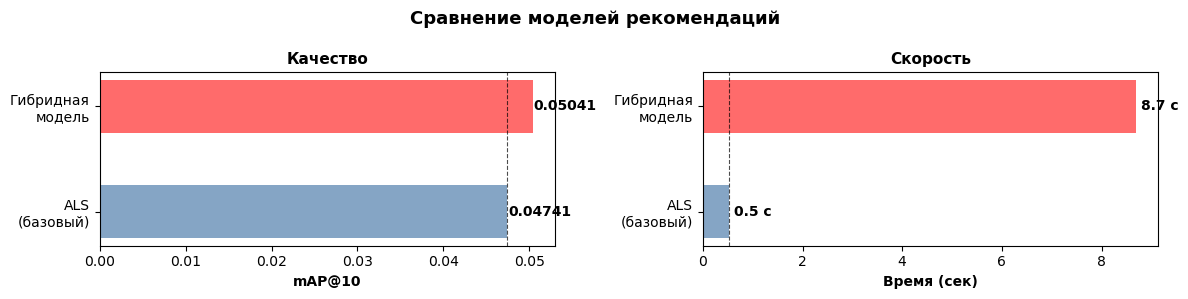

In [383]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3))

# Данные
models = ['ALS\n(базовый)', 'Гибридная\nмодель']
scores = [mean_ap_als_base, mean_ap_hybrid]
times  = [time_model_als_base, time_model_hybrid]
colors = ['#85A5C5', '#FF6B6B']

# График качества
bars1 = axes[0].barh(models, scores, color=colors, height=0.5)
axes[0].axvline(x=mean_ap_als_base, color='black', linestyle='--', linewidth=0.8, alpha=0.7)

for bar, score in zip(bars1, scores):
    axes[0].text(score + 0.0001, bar.get_y() + bar.get_height()/2, f'{score:.5f}', va='center', fontsize=10, fontweight='bold')

axes[0].set_xlabel('mAP@10',  fontsize=10, fontweight='bold')
axes[0].set_title('Качество', fontsize=11, fontweight='bold')

# График времени
bars2 = axes[1].barh(models, times, color=colors, height=0.5)
axes[1].axvline(x=time_model_als_base, color='black', linestyle='--', linewidth=0.8, alpha=0.7)

for bar, time_val in zip(bars2, times):
    axes[1].text(time_val + 0.1, bar.get_y() + bar.get_height()/2, f'{time_val:.1f} с', va='center', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Время (сек)', fontsize=10, fontweight='bold')
axes[1].set_title('Скорость',     fontsize=11, fontweight='bold')

fig.suptitle('Сравнение моделей рекомендаций', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

### Выводы (Часть 3)

#### Гибридный метод (ALS + CatBoost)
- Собраны контентные признаки (статистика, жанры, взаимодействия)
- Обучен и откалиброван классификатор **CatBoost**
- Рекомендации ALS ранжированы с помощью вероятностей CatBoost
- Лучший результат при `weight_coef=0.5`:
  - **mAP@10 гибридной модели: 0,050410**
  - Улучшение к ALS: **+6,3%**
- Гибридный метод работает дольше (8,7 с против 0,5 с), но даёт более точные рекомендации

## Общие итоги и выводы

1.  **Создана гибридная система**, сочетающая коллаборативную (ALS) и контентную (CatBoost) фильтрацию

2.  **Качество**:
    - Базовый ALS: **mAP@10 = 0,047412**
    - Гибридная модель: **mAP@10 = 0,050410** (+6,3%)
    - Комбинация методов улучшает персонализацию

3.  **Оптимальные параметры**:
    - Наилучший баланс между ALS и CatBoost достигается при весе 0.5
    - Превышение веса классификатора снижает качество

4.  **Производительность**:
    - ALS работает быстрее (0,5 сек), гибридная модель требует больше времени (8,7 сек) за счёт генерации признаков и предсказаний

**Итог**: 
- Гибридный подход доказал свою эффективность, обеспечив более точные рекомендации за счёт сочетания в себе двух методов. 